# CMA-ES

CMA-ES is not implemented in PINTS, so doesn't need extensive testing here.
Nonetheless, a number of examples are shown below.
These will be used to design tests for CMA-ES and similar methods such as xNES and SNES.
The results can also be used to compare PINTS implementations of ES methods with this external one.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.toy
import pints.cptests.cmaes as cp

from utils import (
    function,
    function_between_points,
    technicolor_dreamline,
    run_replicates,
)

method = pints.CMAES
parallel = True

## Logistic model - no transformations

We start by tring CMA-ES on a simple 2d logistic model, without applying transformations.

In [2]:
model = pints.toy.LogisticModel()

xtrue = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(xtrue, times)
values += np.random.normal(0, 5, values.shape)
problem = pints.SingleOutputProblem(model, times, values)

error = pints.SumOfSquaresError(problem)
xlim = [0, 0.5]
ylim = [10, 100]
boundaries = pints.RectangularBoundaries(
    [xlim[0], ylim[0]], [xlim[1], ylim[1]])

x0 = boundaries.sample(1)[0]

In [3]:
controller = pints.OptimisationController(
    error, x0, boundaries=boundaries, method=method)
#controller.set_log_to_screen(False)
controller.set_parallel(False)  # This is faster

b = pints.Timer()
xbest, fbest = controller.run()
print(b.format())

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6      19050.37  19050.37   0:00.0
1     12     16386.14  16386.14   0:00.0
2     18     16386.14  18062.09   0:00.0
3     24     16386.14  16496.15   0:00.0
20    126    11326.67  11326.67   0:00.0
40    246    2537.124  2561.163   0:00.1
60    366    2537.089  2537.089   0:00.1
80    486    2537.089  2537.089   0:00.1
100   606    2537.089  2537.089   0:00.1
120   726    2537.089  2537.089   0:00.1
140   846    2537.089  2537.089   0:00.2
160   966    2537.089  2537.089   0:00.2
180   1086   2537.089  2537.089   0:00.2
200   1206   2537.089  2537.089   0:00.2
220   1326   2537.089  2537.089   0:00.2
240   1446   2537.089  2537.089   0:00.3
260   1566   2537.089  2537.089   0:00.3
280   1686   2537.089  2537.089   0:00.3
300   1800   2537.089  2537.089   0:00.3
Halting: No significant change for 200 iterat

  Found       xbest        Relative error
   9.903e-02   1.000e-01  -0.969% 
   4.881e+01   5.000e+01  -2.380% 



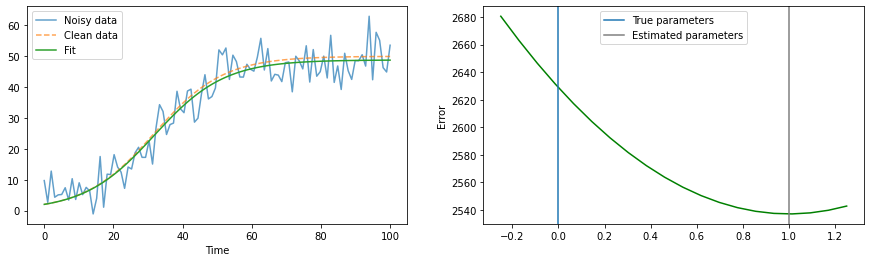

In [4]:
print('  Found       xbest        Relative error' )
for x, y in zip(xbest, xtrue):
    e = (x - y) / y    
    print(f'  {x:> 3.3e}  {y:> 3.3e}  {e:> 3.3%} ')
print()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time')
ax.set_label('Value')
ax.plot(times, values, label='Noisy data', alpha=0.7)
ax.plot(times, problem.evaluate(xtrue), '--', label='Clean data', alpha=0.7)
ax.plot(times, problem.evaluate(xbest), label='Fit')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
function_between_points(ax, error, xtrue, xbest)

plt.show()

The results show that we _almost_ find the correct parameters.
By plotting the error function we can see that this isn't the optimiser's fault: the noise has introduced a bias to which we overfit.

### Detailed run

We can also plot the optimiser's progress through parameter space.

In [5]:
x0 = [0.4, 90]
opt = method(x0, boundaries=boundaries)
walk = [x0]
for i in range(80):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

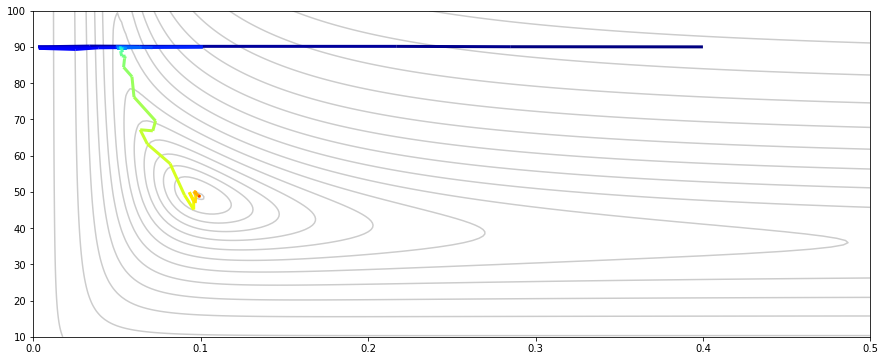

In [6]:
# Create points for contour plot of marginal density
levels = np.geomspace(1e3, 4e5, 20)
x = np.linspace(*xlim, 200)
y = np.linspace(*ylim, 150)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

The optimiser starts with large exploratory steps, during which it figures out the relative scales of the parameters (blue section).
From there on, it starts moving towards the optimum.

## Neal's funnel

Neal's funnel is a hard function to sample from.
We can test if it's also hard to optimise.
(Note that we only plot 2 out of 10 dimensions here).

In [7]:
log_pdf = pints.toy.NealsFunnelLogPDF()
x0 = 9 * np.ones(10, dtype=float)
x0[-1] = 7

opt = method(x0)
walk = [x0]
for i in range(200):
    opt.tell([-log_pdf(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

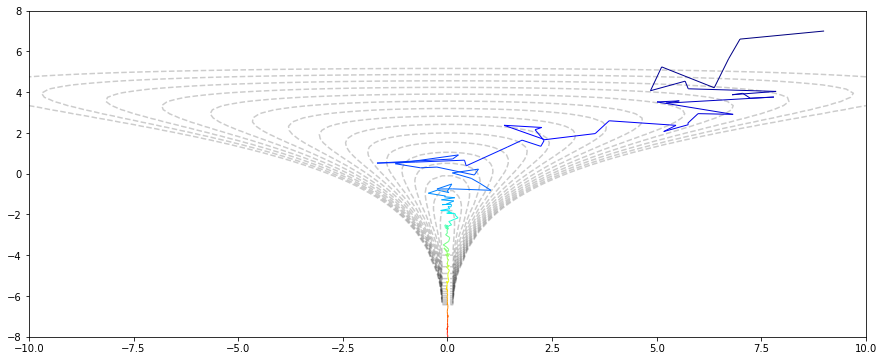

In [8]:
# Create points for contour plot of marginal density
xlim = -10, 10
ylim = -8, 8
levels = np.linspace(-7, -1, 20)
x = np.linspace(*xlim, 80)
y = np.linspace(*ylim, 80)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf.marginal_log_pdf(i, j) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 9])
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Doesn't seem so!

## Rosenbrock function

We can repeat this trick on the Rosenbrock function (which is not _too_ hard, Nelder-Mead can solve it).

In [9]:
error = pints.toy.RosenbrockError()
x0 = [-4, -2]

opt = method(x0)
walk = [x0]
for i in range(150):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

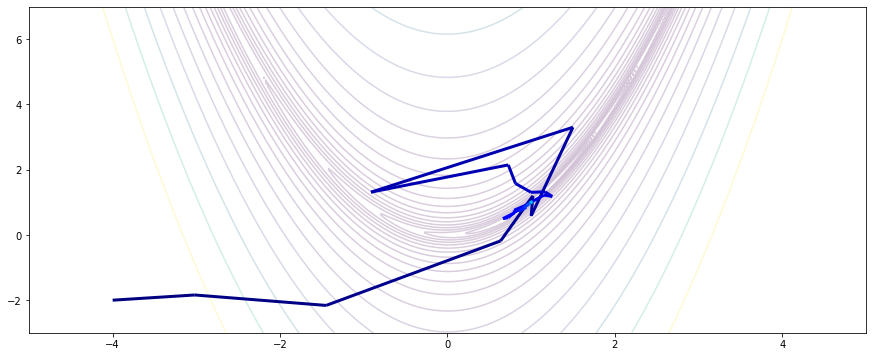

In [10]:
# Create points for contour plot of marginal density
xlim = [-5, 5]
ylim = [-3, 7]
levels = np.geomspace(1, 1e4, 20) - 1
x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Again, it takes a few exploratory steps after which it quickly moves towards the optimum.
We can zoom in, to see the rest:

1.586005957157747e-08 0.022600062499999515


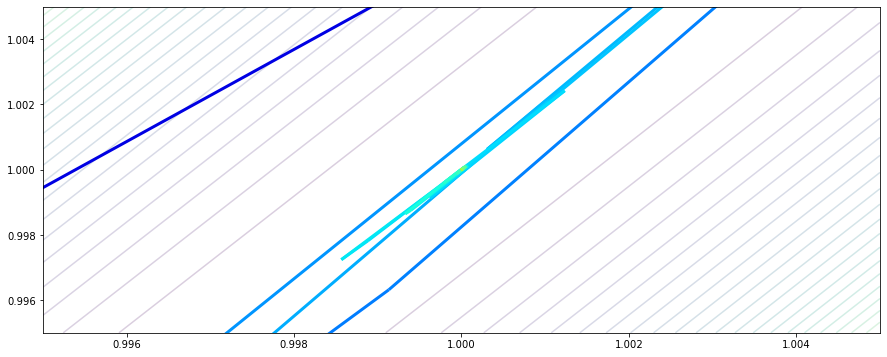

In [11]:
# Create points for contour plot of marginal density
xbest = walk[-1, :]
xlim = [xbest[0] - 0.005, xbest[0] + 0.005]
ylim = [xbest[1] - 0.005, xbest[1] + 0.005]
levels = np.geomspace(1, 1.03, 30) - 1
x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

print(np.min(Z), np.max(Z))

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

## Fitzhugh-Nagumo model - fully observable

The Fitzhugh-Nagumo model is periodic, which can make it slightly tricky perhaps?

In [12]:
model = pints.toy.FitzhughNagumoModel()

xtrue = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(xtrue, times)
r = np.random.default_rng(1)  # Create a seeded generator to get reproducible noise
values += r.normal(0, 0.5, values.shape)
problem = pints.MultiOutputProblem(model, times, values)

error = pints.SumOfSquaresError(problem)
xlim = [1e-3, 2]
ylim = [1e-3, 2]
zlim = [1e-3, 10]
boundaries = np.vstack((xlim, ylim, zlim)).T
boundaries = pints.RectangularBoundaries(boundaries[0], boundaries[1])

In [13]:
# Use a fixed starting point for this one
x0 = xtrue * 1.3

controller = pints.OptimisationController(
    error, x0, boundaries=boundaries, method=method)
controller.set_parallel(parallel)

b = pints.Timer()
xbest, fbest = controller.run()
print(b.format())

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 7 worker processes.
Population size: 7
Iter. Eval. Best      Current   Time    
0     7      574.2857  574.2857   0:00.1
1     14     290.6976  290.6976   0:00.1
2     21     87.96281  87.96281   0:00.1
3     28     87.96281  139.6108   0:00.2
20    147    83.70545  87.3873    0:00.7
40    287    83.08263  83.10053   0:01.7
60    427    83.07136  83.07137   0:02.8
80    567    83.07134  83.07134   0:03.9
100   707    83.07134  83.07134   0:05.1
120   847    83.07134  83.07134   0:06.2
140   987    83.07134  83.07134   0:07.3
160   1127   83.07134  83.07134   0:08.4
180   1267   83.07134  83.07134   0:09.1
200   1407   83.07134  83.07134   0:09.7
220   1547   83.07134  83.07134   0:10.3
240   1687   83.07134  83.07134   0:11.5
260   1827   83.07134  83.07134   0:12.7
280   1967   83.07134  83.07134   0:13.8
300   2107   83.07134  83.07134   0:14.8
320   2247   83.07134  83.07

  Found       xbest        Relative error
   8.713e-02   1.000e-01  -12.872% 
   5.733e-01   5.000e-01   14.663% 
   2.929e+00   3.000e+00  -2.358% 



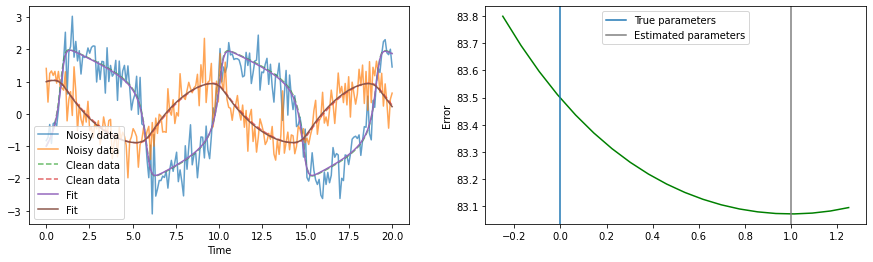

In [14]:
print('  Found       xbest        Relative error' )
for x, y in zip(xbest, xtrue):
    e = (x - y) / y    
    print(f'  {x:> 3.3e}  {y:> 3.3e}  {e:> 3.3%} ')
print()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time')
ax.set_label('Value')
ax.plot(times, values, label='Noisy data', alpha=0.7)
ax.plot(times, problem.evaluate(xtrue), '--', label='Clean data', alpha=0.7)
ax.plot(times, problem.evaluate(xbest), label='Fit')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
function_between_points(ax, error, xtrue, xbest)

plt.show()

As before, the optimiser seems to find the right answer without too much difficulties. But we had to cheat a bit here by choosing a good starting point! It doesn't seem to find the optimum from all random points within the boundaries!

### Detailed run

In [15]:
# Create points for contour plot of marginal density
def contour(xlim, ylim, idx):
    n = 80
    x = np.linspace(*xlim, n)
    y = np.linspace(*ylim, n)
    X, Y = np.meshgrid(x, y)
    Z = [[error(idx(i, j)) for i in x] for j in y]
    print(np.min(Z), np.max(Z))
    return X, Y, Z

n = 100
X1, Y1, Z1 = contour(xlim, ylim, idx=lambda i, j: [i, j, xtrue[2]])
levels1 = np.geomspace(95, 1250, n)
X2, Y2, Z2 = contour(xlim, zlim, idx=lambda i, j: [i, xtrue[1], j])
levels2 = np.geomspace(95, 1000, n)
X3, Y3, Z3 = contour(ylim, zlim, idx=lambda i, j: [xtrue[0], i, j])
levels3 = np.geomspace(95, 1e3, n)

83.59882874778327 1535.472422939695
84.28386356034511 7589.604854692392
83.40920637194193 6013931.213248802


In [16]:
np.random.seed(1)
x0 = [0.75, 1.5, 3]
opt = method(x0, boundaries=boundaries)
walk = [x0]
for i in range(400):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)
np.random.seed()

print(opt.f_guessed())

83.07134493234602


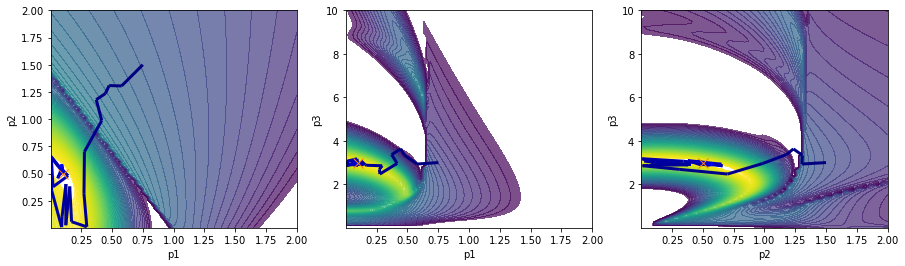

In [17]:
# Plot contours and optimiser progress
def fig3():
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.contourf(X1, Y1, Z1, levels=levels1, cmap='viridis_r', alpha=0.7)
    ax1.set_xlim(*xlim); ax1.set_ylim(*ylim)
    ax1.set_xlabel('p1'); ax1.set_ylabel('p2')
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.contourf(X2, Y2, Z2, levels=levels2, cmap='viridis_r', alpha=0.7)
    ax2.set_xlim(*xlim); ax2.set_ylim(*zlim)
    ax2.set_xlabel('p1'); ax2.set_ylabel('p3')
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.contourf(X3, Y3, Z3, levels=levels3, cmap='viridis_r', alpha=0.7)
    ax3.set_xlim(*ylim); ax3.set_ylim(*zlim)
    ax3.set_xlabel('p2'); ax3.set_ylabel('p3')
    return fig, ax1, ax2, ax3

def p3(ax1, ax2, ax3, x, marker='x', markersize=10, color=None):
    ax1.plot(x[0], x[1], marker, markersize=markersize, color=color)
    ax2.plot(x[0], x[2], marker, markersize=markersize, color=color)
    ax3.plot(x[1], x[2], marker, markersize=markersize, color=color)

fig, ax1, ax2, ax3 = fig3()
technicolor_dreamline(ax1, walk[:, 0], walk[:, 1], lw=3)
technicolor_dreamline(ax2, walk[:, 0], walk[:, 2], lw=3)
technicolor_dreamline(ax3, walk[:, 1], walk[:, 2], lw=3)
p3(ax1, ax2, ax3, xtrue)

plt.show()

That's more like it!
These error surfaces look pretty complicated, but CMA-ES does its usual thing of starting off with very big exploratory steps, and then moving towards the solution.

There are some weird areas, and maybe even local optima? 
We can draw orthogonal lines through a few points to explore:

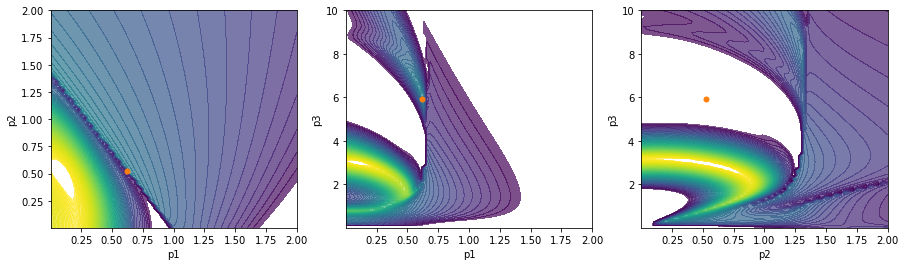

In [18]:
x1 = np.array([0.620, 0.522, 5.91])
fig, ax1, ax2, ax3 = fig3()
p3(ax1, ax2, ax3, x1, '.', 10, color='tab:orange')

The plots below are for the orange point, and show three cross-sections (3 columns) of the score, at two zoom levels (2 rows).

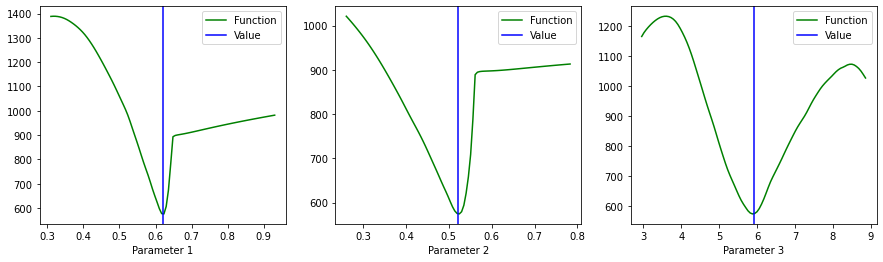

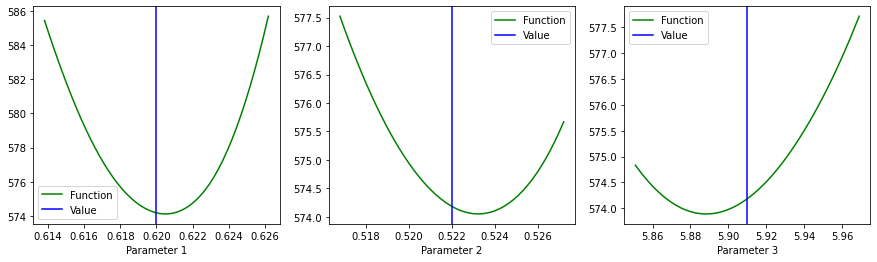

In [19]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)      
function([ax1, ax2, ax3], error, x1, scales=0.5 * x1, evaluations=100)

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)      
function([ax1, ax2, ax3], error, x1, scales=0.01 * x1, evaluations=50)

This looks a bit like a local optima, but tweaking the parameters to land _exactly_ at the lower end of the parabola is hard (changing 1 parameter changes the shapes of the other two curves). Trying out a Nelder-Mead optimisation from that point also led to a very different point after the maximum number of iterations.

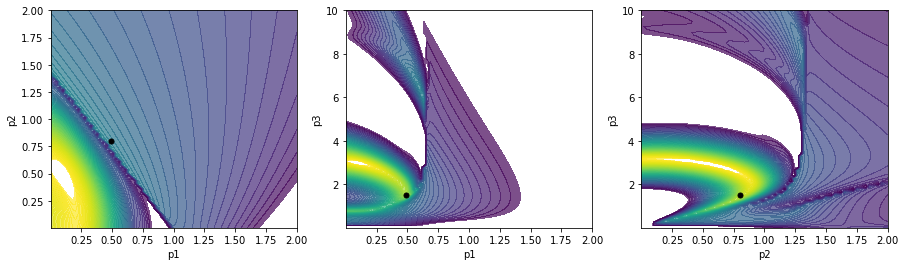

In [20]:
x2 = np.array([0.490, 0.8, 1.5])

fig, ax1, ax2, ax3 = fig3()
p3(ax1, ax2, ax3, x2, '.', 10, color='black')

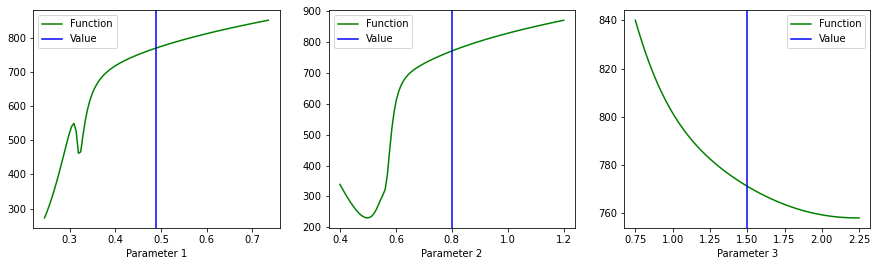

In [21]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)      
function([ax1, ax2, ax3], error, x2, scales=0.5 * x2, evaluations=100)

This looks like a pretty interesting score function!

### Starting point

To select a starting point, we (1) make a guess, (2) plot the score function near that guess, and (3) iterate and refine:

In [22]:
x0 = [0.75, 1.5, 3]

# Create points for contour plot of marginal density
def contour(xlim, ylim, idx):
    n = 80
    x = np.linspace(*xlim, n)
    y = np.linspace(*ylim, n)
    X, Y = np.meshgrid(x, y)
    Z = [[error(idx(i, j)) for i in x] for j in y]
    print(np.min(Z), np.max(Z))
    return X, Y, Z

n = 100
X1, Y1, Z1 = contour(xlim, ylim, idx=lambda i, j: [i, j, x0[2]])
levels1 = np.geomspace(95, 1250, n)
X2, Y2, Z2 = contour(xlim, zlim, idx=lambda i, j: [i, x0[1], j])
levels2 = np.geomspace(95, 1000, n)
X3, Y3, Z3 = contour(ylim, zlim, idx=lambda i, j: [x0[0], i, j])
levels3 = np.geomspace(95, 1e3, n)

83.59882874778327 1535.472422939695
720.2702694385157 1558.2958904172635
312.58378909547474 15225569.114905365


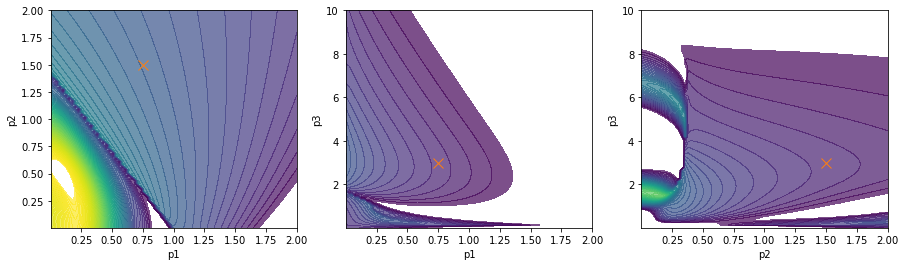

In [23]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax1.contourf(X1, Y1, Z1, levels=levels1, cmap='viridis_r', alpha=0.7)
ax1.set_xlim(*xlim); ax1.set_ylim(*ylim)
ax1.set_xlabel('p1'); ax1.set_ylabel('p2')
ax2 = fig.add_subplot(1, 3, 2)
ax2.contourf(X2, Y2, Z2, levels=levels2, cmap='viridis_r', alpha=0.7)
ax2.set_xlim(*xlim); ax2.set_ylim(*zlim)
ax2.set_xlabel('p1'); ax2.set_ylabel('p3')
ax3 = fig.add_subplot(1, 3, 3)
ax3.contourf(X3, Y3, Z3, levels=levels3, cmap='viridis_r', alpha=0.7)
ax3.set_xlim(*ylim); ax3.set_ylim(*zlim)
ax3.set_xlabel('p2'); ax3.set_ylabel('p3')

ax1.plot(x0[0], x0[1], 'x', markersize=10, color='tab:orange')
ax2.plot(x0[0], x0[2], 'x', markersize=10, color='tab:orange')
ax3.plot(x0[1], x0[2], 'x', markersize=10, color='tab:orange')

Starting here, we might expect the optimiser to make p1 smaller (left on 1st and 2nd graph), make p2 smaller (left on 3d graph), and not do much with p3:

In [24]:
x0 = [0.325, .75, 3]

# Create points for contour plot of marginal density
def contour(xlim, ylim, idx):
    n = 80
    x = np.linspace(*xlim, n)
    y = np.linspace(*ylim, n)
    X, Y = np.meshgrid(x, y)
    Z = [[error(idx(i, j)) for i in x] for j in y]
    print(np.min(Z), np.max(Z))
    return X, Y, Z

n = 100
X1, Y1, Z1 = contour(xlim, ylim, idx=lambda i, j: [i, j, x0[2]])
levels1 = np.geomspace(95, 1250, n)
X2, Y2, Z2 = contour(xlim, zlim, idx=lambda i, j: [i, x0[1], j])
levels2 = np.geomspace(95, 1000, n)
X3, Y3, Z3 = contour(ylim, zlim, idx=lambda i, j: [x0[0], i, j])
levels3 = np.geomspace(95, 1e3, n)

83.59882874778327 1535.472422939695
86.10892015497518 3835.6231067366507
127.85699078005902 8727219.359617624


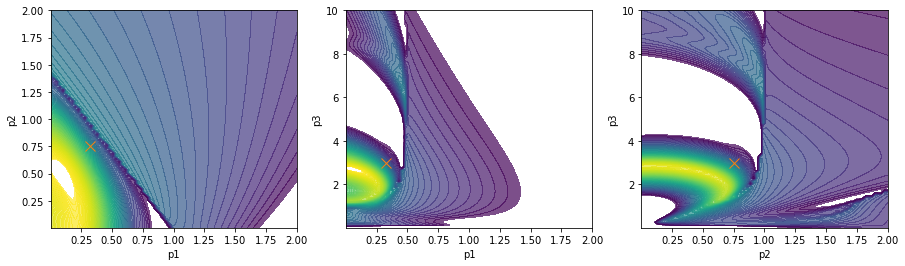

In [25]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax1.contourf(X1, Y1, Z1, levels=levels1, cmap='viridis_r', alpha=0.7)
ax1.set_xlim(*xlim); ax1.set_ylim(*ylim)
ax1.set_xlabel('p1'); ax1.set_ylabel('p2')
ax2 = fig.add_subplot(1, 3, 2)
ax2.contourf(X2, Y2, Z2, levels=levels2, cmap='viridis_r', alpha=0.7)
ax2.set_xlim(*xlim); ax2.set_ylim(*zlim)
ax2.set_xlabel('p1'); ax2.set_ylabel('p3')
ax3 = fig.add_subplot(1, 3, 3)
ax3.contourf(X3, Y3, Z3, levels=levels3, cmap='viridis_r', alpha=0.7)
ax3.set_xlim(*ylim); ax3.set_ylim(*zlim)
ax3.set_xlabel('p2'); ax3.set_ylabel('p3')

ax1.plot(x0[0], x0[1], 'x', markersize=10, color='tab:orange')
ax2.plot(x0[0], x0[2], 'x', markersize=10, color='tab:orange')
ax3.plot(x0[1], x0[2], 'x', markersize=10, color='tab:orange')

And from there on it should be plain sailing? So looks surprisingly doable, despite the crazy shapes.
At the same time, new chasms etc have appeared that we might not have hopped over so easily...
A starting point in the lower-left of panel 1 might be easiest, but leaving it like this for now to have a hard test case.

# Testing performance

## 2D Parabola

If this doesn't work, something is broken.

In [26]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 50, 20), 20, cp.two_dim_parabola, parallel)
print(t.format())

1.24 seconds


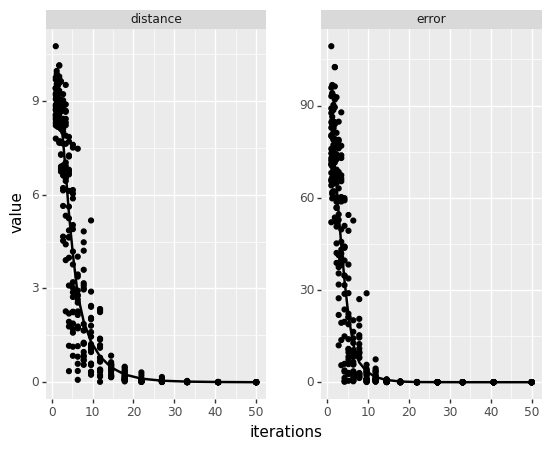

<ggplot: (8790099586001)>

In [27]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.25, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Both lines move in the right direction, and the error quickly goes to zero.

## Rosenbrock error

Now we test on a standard 2d rosenbrock function.

In [28]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 150, 30), 10, cp.rosenbrock, parallel)
print(t.format())

1.57 seconds


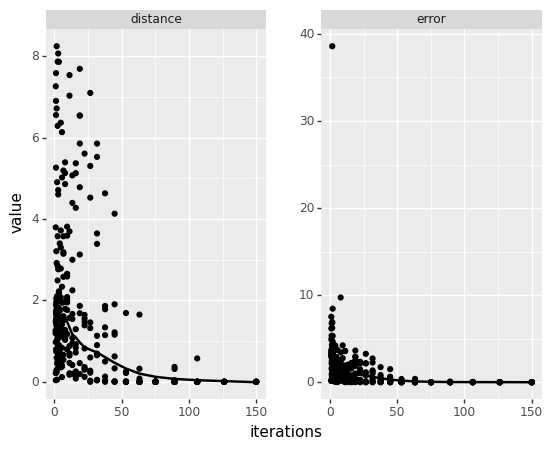

<ggplot: (8790117253117)>

In [29]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The starting position is randomly sampled but chosen to have an error of 10, so we can see that CMAES can take uphill steps at the start.
Note that the smoothed line doesn't capture the trend very well, and just under a 100 iterations are required to get a good result.

## Bounded, untransformed logistic model

Now we fit to a 2d badly scaled time-series problem.

In [30]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 300, 30), 10, cp.bounded_untransformed_logistic, parallel)
print(t.format())

3.7 seconds


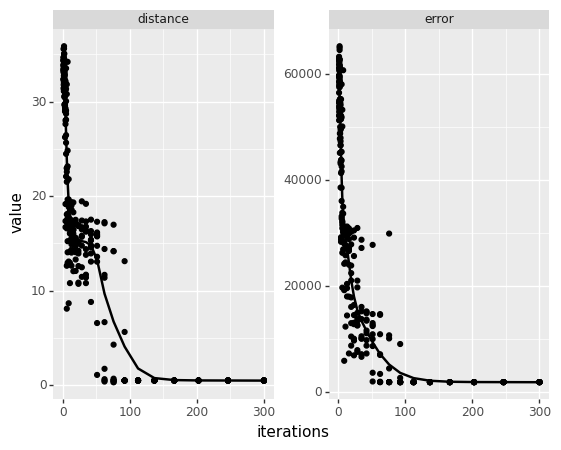

<ggplot: (8790100830237)>

In [31]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

This looks good. Note that:

1. The minimum error is not 0: the smooth curve fitted through the noisy data always has a residual error.
2. The optimal distance is not 0: the noise added to the data causes a bias away from the true solution.

## Bounded Fitzhugh-Nagumo

In [32]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 50, 10), 10, cp.bounded_fitzhugh_nagumo, parallel)
print(t.format())

5.59 seconds


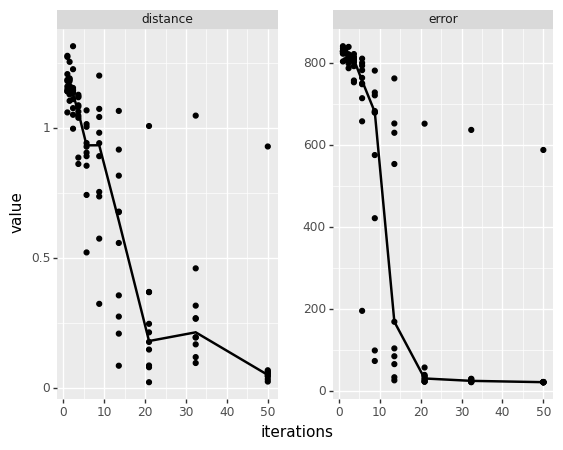

<ggplot: (8790093351241)>

In [33]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

This is an interesting test!

- Convergence is all-or-nothing: Either it gets to almost the right answer in 10-20 iterations, or it gets stuck somewhere (if you don't see any failing examples, try re-running).
- Many runs show an increased distance from ~30 to ~50 iterations: this is presumably the optimiser overfitting to the noise.